This notebook is the start of a notebook series for Healthcom 2020, where we aim to create simulation data as well as a notebook documenting all the code used to obtain results for MLHC.

In [1]:
# The simulation data should have the following features
# demographics - gender, race
# tumour characteristics - primary tumour site, tnm
# laboratory typing - msi-status, kras, braf
# treatment parameters - main_surgery, chemotherapy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Let's initialise some main parameters of the dataset
# We create categorical data first
num_patients = 900
features = {
            'gender': [('male', 0.4), ('female', 0.6)], 
            'race': [('chinese', 0.7), ('malay', 0.2), ('indian', 0.08), ('others', 0.02)], 
            'tumour_site': [('sigmoid', 0.4), ('rectum', 0.4), ('others', 0.2)], 
            't': [('t1', 0.3), ('t2', 0.3), ('t3', 0.4)], 
            'n': [('n1', 0.3), ('n2', 0.4), ('n3', 0.3)], 
            'msi_status': [('mss', 0.7), ('msi', 0.3)], 
            'kras': [('positive', 0.5), ('negative', 0.5)], 
            'braf': [('positive', 0.2), ('negative', 0.8)], 
            'main_surgery': [('colectomy', 0.6), ('laparoscopy', 0.3), ('others', 0.1)], 
            'chemotherapy': [('xeloda', 0.3), ('xelox', 0.3), ('folfox', 0.2), ('others', 0.2)],
            'relapse': [('yes', 0.25), ('no', 0.75)]
           }
SEED = 100

In [4]:
def create_series(name, categories, proportions, length=num_patients):
    #np.random.seed(SEED)
    final_array = np.random.choice(categories, num_patients, p = proportions)
    return pd.Series(final_array, name=name)

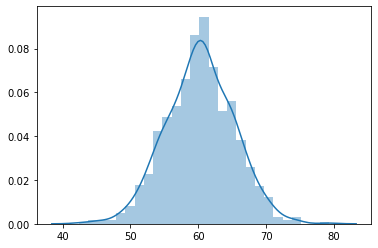

In [5]:
# We also create quantitative data, such as age_at_diagnosis
age_at_diagnosis = np.random.normal(60, 5,size=num_patients)
sns.distplot(age_at_diagnosis)

In [6]:
# Creating the actual dataframe
df = pd.DataFrame(index=range(num_patients))
for feature, data in features.items():
    categories = [category[0] for category in data]
    proportions = [category[1] for category in data]
    new_field = create_series(feature, categories, proportions)
    df = df.join(new_field)
df.head(), df.shape

(   gender     race tumour_site   t   n msi_status      kras      braf  \
 0    male  chinese      others  t3  n2        mss  positive  negative   
 1  female  chinese     sigmoid  t3  n3        mss  positive  negative   
 2  female  chinese      rectum  t2  n2        mss  negative  negative   
 3  female  chinese     sigmoid  t3  n1        mss  positive  negative   
 4    male    malay     sigmoid  t3  n2        mss  negative  negative   
 
   main_surgery chemotherapy relapse  
 0    colectomy       xeloda      no  
 1    colectomy       others     yes  
 2  laparoscopy       others      no  
 3    colectomy       xeloda     yes  
 4  laparoscopy       folfox      no  , (900, 11))

In [7]:
# Checking that the proportions are correct
for col in df.columns:
    print(df[col].value_counts(normalize=True))

female    0.591111
male      0.408889
Name: gender, dtype: float64
chinese    0.747778
malay      0.167778
indian     0.060000
others     0.024444
Name: race, dtype: float64
sigmoid    0.392222
rectum     0.380000
others     0.227778
Name: tumour_site, dtype: float64
t3    0.392222
t2    0.328889
t1    0.278889
Name: t, dtype: float64
n2    0.430000
n3    0.297778
n1    0.272222
Name: n, dtype: float64
mss    0.726667
msi    0.273333
Name: msi_status, dtype: float64
positive    0.51
negative    0.49
Name: kras, dtype: float64
negative    0.803333
positive    0.196667
Name: braf, dtype: float64
colectomy      0.575556
laparoscopy    0.321111
others         0.103333
Name: main_surgery, dtype: float64
xeloda    0.312222
xelox     0.308889
folfox    0.191111
others    0.187778
Name: chemotherapy, dtype: float64
no     0.767778
yes    0.232222
Name: relapse, dtype: float64


In [8]:
# We add in the age data
df['age_at_diagnosis'] = age_at_diagnosis

In [9]:
# We also create the patient_IDs
ids = pd.Series([i+1 for i in range(num_patients)], name='patient_id')
df = df.join(ids)
col = df.pop("age_at_diagnosis")
df.insert(0, col.name, col)
col = df.pop("patient_id")
df.insert(0, col.name, col)
df.head()

,patient_id,age_at_diagnosis,gender,race,tumour_site,t,n,msi_status,kras,braf,main_surgery,chemotherapy,relapse
0,1,64.248191,male,chinese,others,t3,n2,mss,positive,negative,colectomy,xeloda,no
1,2,62.760732,female,chinese,sigmoid,t3,n3,mss,positive,negative,colectomy,others,yes
2,3,67.489125,female,chinese,rectum,t2,n2,mss,negative,negative,laparoscopy,others,no
3,4,58.630061,female,chinese,sigmoid,t3,n1,mss,positive,negative,colectomy,xeloda,yes
4,5,54.115596,male,malay,sigmoid,t3,n2,mss,negative,negative,laparoscopy,folfox,no


In [10]:
# We need to add in relapse date if there is a relapse
# First we define a function to generate a random date within a range
def random_date_generator(start_date, range_in_months):
    months_to_add = np.arange(0, range_in_months)
    random_date = pd.to_datetime(start_date) + pd.DateOffset(months=range_in_months)# + np.random.choice(days_to_add)
    return random_date
random_date_generator('2017-02-01', 60)

Timestamp('2022-02-01 00:00:00')

In [11]:
STARTDATE = '2017-01-01'
DATERANGE = 60
df['relapse_date'] = df['relapse'].apply(lambda x: random_date_generator(STARTDATE, DATERANGE) if x == 'yes' else np.nan)
df.head()

,patient_id,age_at_diagnosis,gender,race,tumour_site,t,n,msi_status,kras,braf,main_surgery,chemotherapy,relapse,relapse_date
0,1,64.248191,male,chinese,others,t3,n2,mss,positive,negative,colectomy,xeloda,no,NaT
1,2,62.760732,female,chinese,sigmoid,t3,n3,mss,positive,negative,colectomy,others,yes,2022-01-01
2,3,67.489125,female,chinese,rectum,t2,n2,mss,negative,negative,laparoscopy,others,no,NaT
3,4,58.630061,female,chinese,sigmoid,t3,n1,mss,positive,negative,colectomy,xeloda,yes,2022-01-01
4,5,54.115596,male,malay,sigmoid,t3,n2,mss,negative,negative,laparoscopy,folfox,no,NaT


In [12]:
def random_walk(num_points, start, prob):
    rr = np.random.random(num_points) # Num points
    downp = rr < prob[0] 
    upp = rr > prob[1]
    positions = [start]
    for idownp, iupp in zip(downp, upp): 
        down = idownp and positions[-1] > 1
        up = iupp and positions[-1] < 50
        if down: direction = -1
        elif up: direction = 1
        else: direction = 0
        position = positions[-1] + np.random.uniform(0, 1) * direction 
        if position < 0: position = 0
        positions.append(position)
    return positions

In [13]:
# We need to create a function to simulate CEA values
# The function should take in patient_ID, relapse status, relapse date if any
def create_ts(id, relapse, relapse_date = None):
    if relapse == 'yes': 
        prob = [0.45, 0.55] # Prob of going upwards is slightly higher
        #np.random.seed(SEED)
        randomInts = np.random.normal(loc=20, scale=3, size=10000).astype(int) # We set mean number of timepoints to 20
    else: 
        prob = [0.5, 0.5]
        #np.random.seed(SEED)
        randomInts = np.random.normal(loc=20, scale=3, size=10000).astype(int) 
    
    #np.random.seed(SEED)
    num_points = np.random.choice(randomInts).astype(int)
    #np.random.seed(SEED)
    start = np.random.uniform(0.05, 0.5) # Randomly generate starting number between this range
    
    # Create the CEA values
    ts = random_walk(num_points, start, prob)
    # Then create the timestamps
    if relapse == 'yes':
        end_date = relapse_date
    else:
        end_date = random_date_generator(STARTDATE, DATERANGE)
    timestamps = [end_date]
    for i in range(num_points-1):
        prev_month = end_date - np.timedelta64(1, 'M')
        timestamps.append(prev_month)
        end_date = prev_month
    timestamps.reverse()
    return id, pd.Series(timestamps).dt.date, pd.Series(ts)
#create_ts(1, 'yes', random_date_generator('2017-02-01', 1000))

In [14]:
tsdf = pd.DataFrame()
temp = df.apply(lambda x: create_ts(x['patient_id'], x['relapse'], x['relapse_date']), axis=1)
for patient in temp:
    tempdf = pd.DataFrame()
    patient_id, timestamps, ts = patient
    tempdf['timestamps'], tempdf['cea'] = timestamps, ts
    tempdf['patient_id'] = patient_id
    tsdf = tsdf.append(tempdf, ignore_index=True)
tsdf.head(30)

,timestamps,cea,patient_id
0,2020-05-02,0.070772,1
1,2020-06-01,0.070772,1
2,2020-07-02,0.070772,1
3,2020-08-01,0.359005,1
4,2020-09-01,0.359005,1
5,2020-10-01,0.359005,1
6,2020-10-31,0.359005,1
7,2020-12-01,0.359005,1
8,2020-12-31,0.359005,1
9,2021-01-31,0.359005,1


In [15]:
# Lastly we plot out some cea graphs to visualise
np.random.seed(100)
random_ids = np.random.choice(a=[i for i in range(900)], size=20, replace=False)
random_ids

array([433, 789, 687,  24, 482, 259,  44, 637, 598, 454, 493, 178, 553,
       374, 796, 330, 634, 883, 644, 768])

/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


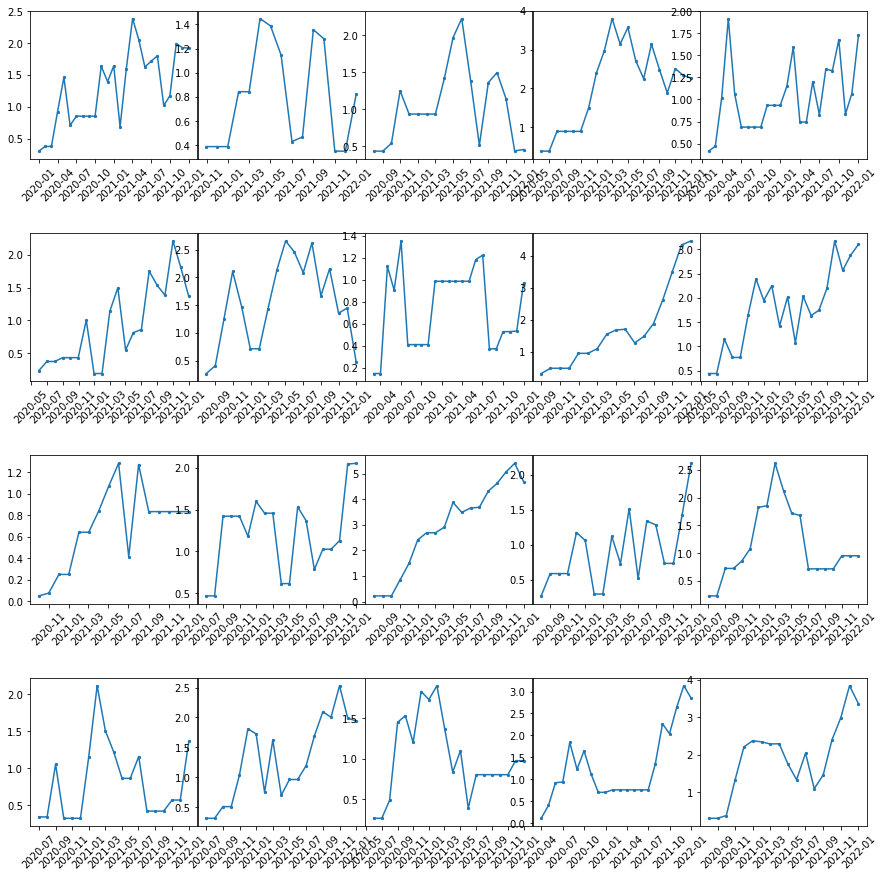

In [16]:
import matplotlib.pyplot as plt
def plot_ts(ids, df):
    fig, axs = plt.subplots(4,5, figsize=(15, 15))
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
    for i in range(len(ids)):
        patid = ids[i]
        cea_vals = df[df['patient_id'] == patid]
        cea_vals.set_index('timestamps', inplace=True, drop=True)
        cea_vals.drop(['patient_id'], axis=1, inplace=True)
        axs[i].plot(cea_vals)
        axs[i].scatter(cea_vals.index, cea_vals.cea, s=5)
        axs[i].tick_params(axis='x', labelrotation=45)
        
plot_ts(random_ids, tsdf)

In [17]:
# Looking good, let's print out
tsdf.to_csv("synthetic_ts.csv", index=False)
df.to_csv("synthetic_structured.csv", index=False)